In [1]:
import tensorflow as tf
import tensorflow.keras as keras

# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Skimage
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure  
from skimage import draw

# train and test split
from sklearn.model_selection import train_test_split

# For data augmentation and callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler
from tensorflow.keras import backend as K

from segmentation_model import unet_model
from segmentation_model import mean_iou, dice_coef, costum_dice_loss

from segmentation_data import X_train_1,Y_train_1, X_train_2,Y_train_2
from segmentation_data import X_test_unlabelled
from segmentation_data import img_height, img_width

In [2]:
print('X_train_1: ', X_train_1.shape, X_train_1.dtype)
print('Y_train_1: ', Y_train_1.shape, Y_train_1.dtype)

print('X_train_2: ', X_train_2.shape, X_train_2.dtype)
print('Y_train_2: ', Y_train_2.shape, Y_train_2.dtype)

print('X_test_unlabelled: ', X_test_unlabelled.shape, X_test_unlabelled.dtype)

X_train_1:  (50, 128, 128, 1) float32
Y_train_1:  (50, 128, 128, 1) float32
X_train_2:  (50, 128, 128, 1) float32
Y_train_2:  (50, 128, 128, 1) float32
X_test_unlabelled:  (470, 128, 128, 1) float32


In [3]:
def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x
    
class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

def scheduler(epoch):
    # 每隔固定个epoch，学习率减小为原来的多少倍
    if epoch % 150 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return K.get_value(model.optimizer.lr)

**注意ImageDataGenerator的fit的作用：**

By using ImageDataGenerator, we should know that some transformations require ***statistics*** of the entire dataset. These transformations include featurewise_center, featurewise_std_normalization and zca_whitening.

To calculate these statistics, first of all, one may need to load the entire dataset into the memory. Then calculate the ***mean, standard deviation, principal components or any other statistics from that data***. Fortunately, Keras has a built-in fit method for doing this. Let’s discuss it in detail.

因此注意，.fit功能只是用于calculate statistics，并没有输出数据，这需要.flow
因此注意，只用X做.fit，再应用到整个(X,Y)理论上也是可以的

In [4]:
# Runtime data augmentation
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())   
        
def get_train_test_augmented(X_data, Y_data, validation_split=0.25, batch_size=32, seed=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=10.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.1,
                         zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=False,
                         fill_mode='nearest')  #use 'constant'??


    # Train data generator, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)    # 只要用同一个seed就能有一样的augmentation
    Y_datagen.fit(Y_train, augment=True, seed=seed)    # augment: Whether to fit on randomly augmented samples.
     
    
    # Test data generator, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)  
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    
    # generates batches of augmented data by using .flow
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    X_val_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_val_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    # combine generators into one which yields image and masks, tf2好像不支持zip, 只能写一个combine_generator函数
    train_generator = combine_generator(X_train_augmented, Y_train_augmented)
    val_generator = combine_generator(X_val_augmented, Y_val_augmented)

    return train_generator, val_generator

# central mask

## show data

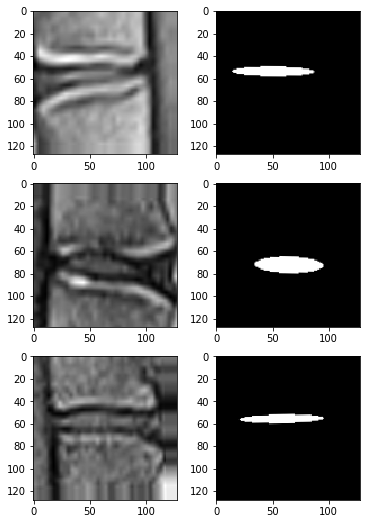

In [5]:
# show train data
train_generator, val_generator = get_train_test_augmented(X_data=X_train_1, 
                                                          Y_data=Y_train_1, 
                                                          validation_split=0.3, 
                                                          batch_size=2, 
                                                          seed=1)
N = 3
plt.figure(figsize=(6,3*N))
for i, (train_x, train_y) in enumerate(train_generator):
    if i>=N:
        break
    plt.subplot(N,2,2*i+1)
    plt.imshow(train_x[0].squeeze(), cmap='gray')
    plt.subplot(N,2,2*i+2)
    plt.imshow(train_y[0].squeeze(), cmap='gray')
plt.show()

## model

In [6]:
#optimizer = keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True) # lr设置成0.1太大 loss会由于bce那一部分梯度爆炸
optimizer = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
loss      = costum_dice_loss
metrics   = ['accuracy']

input_size = (img_height, img_width,1)
model = unet_model(input_size = input_size)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#model.summary()

In [7]:
model_dir = './segmentation_model_weights'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
load_weights = False
if load_weights:
    model.load_weights(filepath=os.path.join(model_dir,"./weights_unet1.hdf5"))

## train 

In [8]:
# callbacks
plot_losses = PlotLosses(figsize=(16, 4))
checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir,"./weights_unet1.hdf5"), verbose=1, monitor='val_loss', save_best_only=True)
# checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet1.hdf5"), verbose=1)
reduce_lr = LearningRateScheduler(scheduler) 

# hyperparameters
epochs = 200
batch_size = 16

seed= 42
validation_split = 0.3
validation_steps = round(X_train_1.shape[0] * validation_split / batch_size)
steps_per_epoch = 3

train_generator, val_generator = get_train_test_augmented(X_data=X_train_1, 
                                                          Y_data=Y_train_1, 
                                                          validation_split=validation_split, 
                                                          batch_size=batch_size, 
                                                          seed=seed)

#Training with augmentation and visualization
history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch, 
                              epochs=epochs, 
                              verbose=1, 
                              #callbacks=[plot_losses, checkpoint, reduce_lr],
                              callbacks=[checkpoint],
                              validation_data=val_generator, 
                              validation_steps=validation_steps, 
                              shuffle=True)

Epoch 1/200
2/3 [===================>..........] - ETA: 3s - loss: 0.2714 - accuracy: 0.9562
Epoch 00001: val_loss improved from inf to 0.25447, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 8s 3s/step - loss: 0.2769 - accuracy: 0.9574 - val_loss: 0.2545 - val_accuracy: 0.9559
Epoch 2/200
2/3 [===================>..........] - ETA: 2s - loss: 0.2581 - accuracy: 0.9543
Epoch 00002: val_loss improved from 0.25447 to 0.24175, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 7s 2s/step - loss: 0.2634 - accuracy: 0.9558 - val_loss: 0.2417 - val_accuracy: 0.9559
Epoch 3/200
2/3 [===================>..........] - ETA: 2s - loss: 0.2282 - accuracy: 0.9567
Epoch 00003: val_loss improved from 0.24175 to 0.18975, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 7s 2s/step - loss: 0.2190 - accuracy: 0.9571 - val_loss: 0.1898 - va

Epoch 28/200
2/3 [===================>..........] - ETA: 2s - loss: -0.1954 - accuracy: 0.9567
Epoch 00028: val_loss did not improve from -0.28359
3/3 [==============================] - 7s 2s/step - loss: -0.1806 - accuracy: 0.9578 - val_loss: -0.2489 - val_accuracy: 0.9559
Epoch 29/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2006 - accuracy: 0.9574
Epoch 00029: val_loss improved from -0.28359 to -0.30164, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 7s 2s/step - loss: -0.2017 - accuracy: 0.9572 - val_loss: -0.3016 - val_accuracy: 0.9559
Epoch 30/200
2/3 [===================>..........] - ETA: 2s - loss: -0.1950 - accuracy: 0.9572
Epoch 00030: val_loss did not improve from -0.30164
3/3 [==============================] - 7s 2s/step - loss: -0.1928 - accuracy: 0.9567 - val_loss: -0.2214 - val_accuracy: 0.9559
Epoch 31/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2093 - accuracy: 0.9572
Epoch 00

Epoch 56/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2782 - accuracy: 0.9292
Epoch 00056: val_loss did not improve from -0.36560
3/3 [==============================] - 7s 2s/step - loss: -0.2923 - accuracy: 0.9292 - val_loss: -0.3428 - val_accuracy: 0.9457
Epoch 57/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2838 - accuracy: 0.9256
Epoch 00057: val_loss did not improve from -0.36560
3/3 [==============================] - 7s 2s/step - loss: -0.2493 - accuracy: 0.9221 - val_loss: -0.3219 - val_accuracy: 0.9437
Epoch 58/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2560 - accuracy: 0.9162
Epoch 00058: val_loss did not improve from -0.36560
3/3 [==============================] - 7s 2s/step - loss: -0.2871 - accuracy: 0.9173 - val_loss: -0.3089 - val_accuracy: 0.9435
Epoch 59/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2940 - accuracy: 0.9306
Epoch 00059: val_loss did not improve from -0.36560
3/3 [=======================

Epoch 84/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3406 - accuracy: 0.9382
Epoch 00084: val_loss did not improve from -0.40018
3/3 [==============================] - 7s 2s/step - loss: -0.3425 - accuracy: 0.9376 - val_loss: -0.3731 - val_accuracy: 0.9481
Epoch 85/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3290 - accuracy: 0.9322
Epoch 00085: val_loss did not improve from -0.40018
3/3 [==============================] - 7s 2s/step - loss: -0.3245 - accuracy: 0.9312 - val_loss: -0.3918 - val_accuracy: 0.9518
Epoch 86/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3647 - accuracy: 0.9402
Epoch 00086: val_loss did not improve from -0.40018
3/3 [==============================] - 7s 2s/step - loss: -0.3477 - accuracy: 0.9388 - val_loss: -0.3824 - val_accuracy: 0.9517
Epoch 87/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3434 - accuracy: 0.9412
Epoch 00087: val_loss did not improve from -0.40018
3/3 [=======================

Epoch 112/200
2/3 [===================>..........] - ETA: 2s - loss: -0.4507 - accuracy: 0.9668
Epoch 00112: val_loss did not improve from -0.46771
3/3 [==============================] - 7s 2s/step - loss: -0.4206 - accuracy: 0.9658 - val_loss: -0.4676 - val_accuracy: 0.9726
Epoch 113/200
2/3 [===================>..........] - ETA: 2s - loss: -0.4493 - accuracy: 0.9657
Epoch 00113: val_loss did not improve from -0.46771
3/3 [==============================] - 7s 2s/step - loss: -0.4547 - accuracy: 0.9655 - val_loss: -0.4671 - val_accuracy: 0.9733
Epoch 114/200
2/3 [===================>..........] - ETA: 2s - loss: -0.4613 - accuracy: 0.9676
Epoch 00114: val_loss improved from -0.46771 to -0.47193, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 7s 2s/step - loss: -0.4456 - accuracy: 0.9674 - val_loss: -0.4719 - val_accuracy: 0.9761
Epoch 115/200
2/3 [===================>..........] - ETA: 2s - loss: -0.4483 - accuracy: 0.9685
Epoc

2/3 [===================>..........] - ETA: 2s - loss: -0.5077 - accuracy: 0.9781
Epoch 00140: val_loss did not improve from -0.51134
3/3 [==============================] - 7s 2s/step - loss: -0.5159 - accuracy: 0.9783 - val_loss: -0.5097 - val_accuracy: 0.9817
Epoch 141/200
2/3 [===================>..........] - ETA: 2s - loss: -0.4991 - accuracy: 0.9743
Epoch 00141: val_loss improved from -0.51134 to -0.51170, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 7s 2s/step - loss: -0.5020 - accuracy: 0.9743 - val_loss: -0.5117 - val_accuracy: 0.9815
Epoch 142/200
2/3 [===================>..........] - ETA: 2s - loss: -0.5156 - accuracy: 0.9782
Epoch 00142: val_loss did not improve from -0.51170
3/3 [==============================] - 7s 2s/step - loss: -0.5041 - accuracy: 0.9785 - val_loss: -0.5082 - val_accuracy: 0.9813
Epoch 143/200
2/3 [===================>..........] - ETA: 2s - loss: -0.5198 - accuracy: 0.9794
Epoch 00143: val_l

2/3 [===================>..........] - ETA: 1s - loss: -0.5185 - accuracy: 0.9784
Epoch 00169: val_loss did not improve from -0.51406
3/3 [==============================] - 4s 1s/step - loss: -0.5337 - accuracy: 0.9788 - val_loss: -0.5071 - val_accuracy: 0.9812
Epoch 170/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5242 - accuracy: 0.9780
Epoch 00170: val_loss did not improve from -0.51406
3/3 [==============================] - 4s 1s/step - loss: -0.5034 - accuracy: 0.9775 - val_loss: -0.5088 - val_accuracy: 0.9811
Epoch 171/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5289 - accuracy: 0.9789
Epoch 00171: val_loss did not improve from -0.51406
3/3 [==============================] - 4s 1s/step - loss: -0.5223 - accuracy: 0.9791 - val_loss: -0.5113 - val_accuracy: 0.9808
Epoch 172/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5107 - accuracy: 0.9773
Epoch 00172: val_loss did not improve from -0.51406
3/3 [==============================] -

2/3 [===================>..........] - ETA: 1s - loss: -0.5369 - accuracy: 0.9801
Epoch 00197: val_loss did not improve from -0.52593
3/3 [==============================] - 4s 1s/step - loss: -0.5460 - accuracy: 0.9802 - val_loss: -0.5201 - val_accuracy: 0.9822
Epoch 198/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5451 - accuracy: 0.9813
Epoch 00198: val_loss did not improve from -0.52593
3/3 [==============================] - 4s 1s/step - loss: -0.5382 - accuracy: 0.9810 - val_loss: -0.5224 - val_accuracy: 0.9828
Epoch 199/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5363 - accuracy: 0.9808
Epoch 00199: val_loss improved from -0.52593 to -0.52763, saving model to ./segmentation_model_weights\./weights_unet1.hdf5
3/3 [==============================] - 4s 1s/step - loss: -0.5454 - accuracy: 0.9808 - val_loss: -0.5276 - val_accuracy: 0.9831
Epoch 200/200
2/3 [===================>..........] - ETA: 1s - loss: -0.5509 - accuracy: 0.9814
Epoch 00200: val_l

## draw figures 


history val_loss:


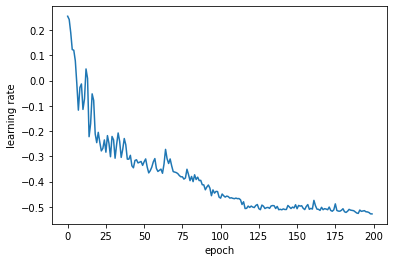

In [11]:
print('\nhistory val_loss:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_loss']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()


history val_accuracy:


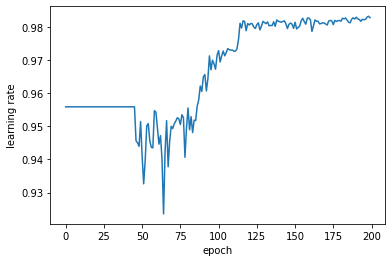

In [12]:
print('\nhistory val_accuracy:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_accuracy']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

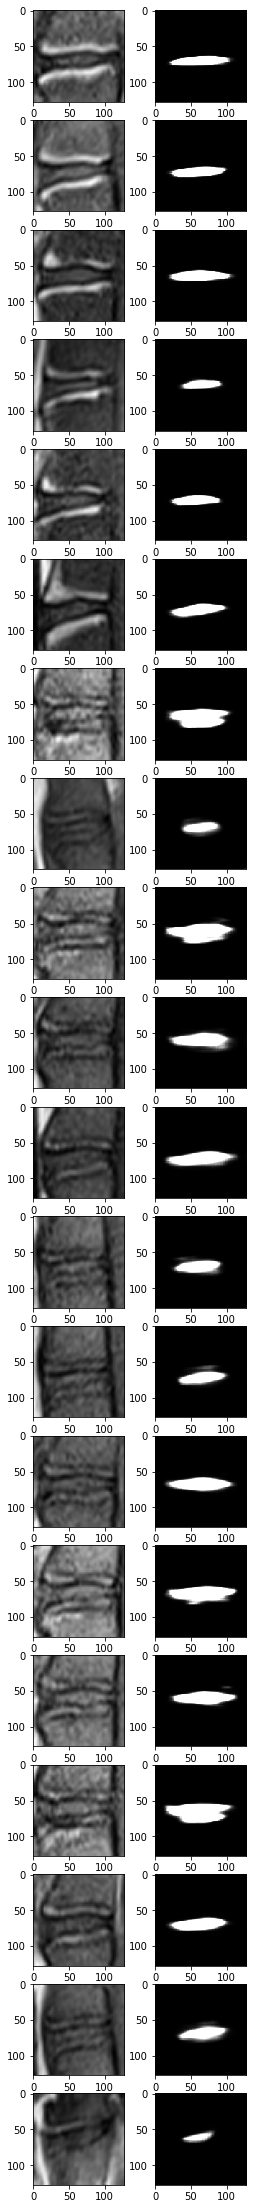

In [13]:
Y_pred = model.predict(X_test_unlabelled)
X_test_show = np.squeeze(X_test_unlabelled)
Y_pred_show = np.squeeze(Y_pred)

plt.figure(figsize=(4,40))
for i in range(20):
    plt.subplot(20,2,2*(i+1)-1)
    plt.imshow(X_test_show[i,:,:],cmap = 'gray')
    plt.subplot(20,2,2*(i+1))
    plt.imshow(Y_pred_show[i,:,:],cmap = 'gray')
plt.show()

# sides mask

## preparation

In [14]:
def get_train_test_augmented(X_data, Y_data, validation_split=0.25, batch_size=32, seed=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=10.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         #shear_range=0.1,
                         #zoom_range=0.1,
                         horizontal_flip=True,
                         vertical_flip=False,
                         fill_mode='nearest')  #use 'constant'??


    # Train data generator, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)    # 只要用同一个seed就能有一样的augmentation
    Y_datagen.fit(Y_train, augment=True, seed=seed)    # augment: Whether to fit on randomly augmented samples.
     
    
    # Test data generator, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)  
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    
    # generates batches of augmented data by using .flow
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    X_val_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_val_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    # combine generators into one which yields image and masks, tf2好像不支持zip, 只能写一个combine_generator函数
    train_generator = combine_generator(X_train_augmented, Y_train_augmented)
    val_generator = combine_generator(X_val_augmented, Y_val_augmented)

    return train_generator, val_generator

## show data

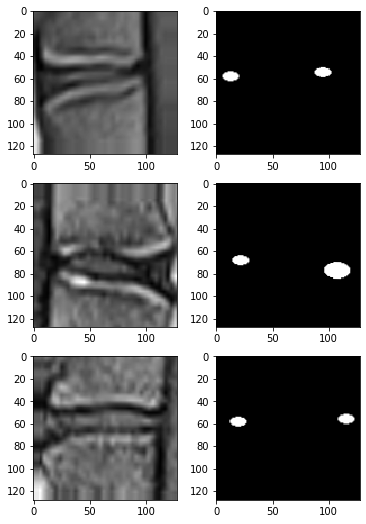

In [15]:
# show train data
train_generator, val_generator = get_train_test_augmented(X_data=X_train_2, 
                                                          Y_data=Y_train_2, 
                                                          validation_split=0.3, 
                                                          batch_size=2, 
                                                          seed=1)
N = 3
plt.figure(figsize=(6,3*N))
for i, (train_x, train_y) in enumerate(train_generator):
    if i>=N:
        break
    plt.subplot(N,2,2*i+1)
    plt.imshow(train_x[0].squeeze(), cmap='gray')
    plt.subplot(N,2,2*i+2)
    plt.imshow(train_y[0].squeeze(), cmap='gray')
plt.show()

## model

In [16]:
#optimizer = keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True) # lr设置成0.1太大 loss会由于bce那一部分梯度爆炸
optimizer = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
loss      = costum_dice_loss
metrics   = ['accuracy']

input_size = (img_height, img_width,1)
model = unet_model(input_size = input_size)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#model.summary()

In [17]:
model_dir = './segmentation_model_weights'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
load_weights = False
if load_weights:
    model.load_weights(filepath=os.path.join(model_dir,"./weights_unet2.hdf5"))

## train 

In [18]:
# callbacks
plot_losses = PlotLosses(figsize=(16, 4))
checkpoint = ModelCheckpoint(filepath=os.path.join(model_dir,"./weights_unet2.hdf5"), verbose=1, monitor='val_loss', save_best_only=True)
#checkpoint = ModelCheckpoint(filepath=os.path.join(log_dir,"./weights_unet2.hdf5"), verbose=1)
reduce_lr = LearningRateScheduler(scheduler) 

# hyperparameters
epochs = 200
batch_size = 16

seed= 42
steps_per_epoch = 3
validation_split = 0.3
validation_steps = round(X_train_1.shape[0] * validation_split / batch_size)

#Training with augmentation and visualization
train_generator, val_generator = get_train_test_augmented(X_data=X_train_2, 
                                                          Y_data=Y_train_2, 
                                                          validation_split=validation_split, 
                                                          batch_size=batch_size, 
                                                          seed=seed)
history = model.fit_generator(train_generator, 
                               steps_per_epoch=steps_per_epoch, 
                               epochs=epochs, 
                               verbose=1, 
                               #callbacks=[plot_losses, checkpoint, reduce_lr],
                               callbacks=[checkpoint, reduce_lr],
                               validation_data=val_generator, 
                               validation_steps=validation_steps, 
                               shuffle=True)

Epoch 1/200
2/3 [===================>..........] - ETA: 1s - loss: 0.1382 - accuracy: 0.9796
Epoch 00001: val_loss improved from inf to 0.07989, saving model to ./segmentation_model_weights\./weights_unet2.hdf5
3/3 [==============================] - 5s 2s/step - loss: 0.1241 - accuracy: 0.9800 - val_loss: 0.0799 - val_accuracy: 0.9839
Epoch 2/200
2/3 [===================>..........] - ETA: 1s - loss: 0.1071 - accuracy: 0.9800
Epoch 00002: val_loss improved from 0.07989 to 0.06242, saving model to ./segmentation_model_weights\./weights_unet2.hdf5
3/3 [==============================] - 5s 2s/step - loss: 0.1078 - accuracy: 0.9800 - val_loss: 0.0624 - val_accuracy: 0.9839
Epoch 3/200
2/3 [===================>..........] - ETA: 1s - loss: 0.0756 - accuracy: 0.9808
Epoch 00003: val_loss did not improve from 0.06242
3/3 [==============================] - 5s 2s/step - loss: 0.0699 - accuracy: 0.9800 - val_loss: 0.0677 - val_accuracy: 0.9839
Epoch 4/200
2/3 [===================>..........] - E

Epoch 27/200
2/3 [===================>..........] - ETA: 1s - loss: -0.2376 - accuracy: 0.9757
Epoch 00027: val_loss did not improve from -0.28993
3/3 [==============================] - 4s 1s/step - loss: -0.2212 - accuracy: 0.9754 - val_loss: -0.2715 - val_accuracy: 0.9829
Epoch 28/200
2/3 [===================>..........] - ETA: 1s - loss: -0.2516 - accuracy: 0.9754
Epoch 00028: val_loss did not improve from -0.28993
3/3 [==============================] - 4s 1s/step - loss: -0.2961 - accuracy: 0.9761 - val_loss: -0.2171 - val_accuracy: 0.9844
Epoch 29/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2171 - accuracy: 0.9809
Epoch 00029: val_loss improved from -0.28993 to -0.29380, saving model to ./segmentation_model_weights\./weights_unet2.hdf5
3/3 [==============================] - 5s 2s/step - loss: -0.2282 - accuracy: 0.9806 - val_loss: -0.2938 - val_accuracy: 0.9828
Epoch 30/200
2/3 [===================>..........] - ETA: 2s - loss: -0.2169 - accuracy: 0.9604
Epoch 00

2/3 [===================>..........] - ETA: 1s - loss: -0.3053 - accuracy: 0.9749
Epoch 00054: val_loss did not improve from -0.36366
3/3 [==============================] - 5s 2s/step - loss: -0.2963 - accuracy: 0.9748 - val_loss: -0.3482 - val_accuracy: 0.9842
Epoch 55/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3063 - accuracy: 0.9724
Epoch 00055: val_loss did not improve from -0.36366
3/3 [==============================] - 5s 2s/step - loss: -0.2935 - accuracy: 0.9727 - val_loss: -0.3417 - val_accuracy: 0.9852
Epoch 56/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3137 - accuracy: 0.9754
Epoch 00056: val_loss did not improve from -0.36366
3/3 [==============================] - 4s 1s/step - loss: -0.3014 - accuracy: 0.9751 - val_loss: -0.3399 - val_accuracy: 0.9849
Epoch 57/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3219 - accuracy: 0.9780
Epoch 00057: val_loss did not improve from -0.36366
3/3 [==============================] - 4s

Epoch 84/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3499 - accuracy: 0.9806
Epoch 00084: val_loss did not improve from -0.36422
3/3 [==============================] - 4s 1s/step - loss: -0.3435 - accuracy: 0.9808 - val_loss: -0.3523 - val_accuracy: 0.9819
Epoch 85/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3512 - accuracy: 0.9764
Epoch 00085: val_loss did not improve from -0.36422
3/3 [==============================] - 5s 2s/step - loss: -0.3347 - accuracy: 0.9762 - val_loss: -0.3581 - val_accuracy: 0.9812
Epoch 86/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3453 - accuracy: 0.9777
Epoch 00086: val_loss did not improve from -0.36422
3/3 [==============================] - 5s 2s/step - loss: -0.3180 - accuracy: 0.9772 - val_loss: -0.3541 - val_accuracy: 0.9849
Epoch 87/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3598 - accuracy: 0.9806
Epoch 00087: val_loss did not improve from -0.36422
3/3 [=======================

Epoch 113/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3774 - accuracy: 0.9798
Epoch 00113: val_loss did not improve from -0.38959
3/3 [==============================] - 5s 2s/step - loss: -0.3824 - accuracy: 0.9799 - val_loss: -0.3788 - val_accuracy: 0.9840
Epoch 114/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3926 - accuracy: 0.9817
Epoch 00114: val_loss did not improve from -0.38959
3/3 [==============================] - 5s 2s/step - loss: -0.3748 - accuracy: 0.9819 - val_loss: -0.3817 - val_accuracy: 0.9837
Epoch 115/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3619 - accuracy: 0.9794
Epoch 00115: val_loss did not improve from -0.38959
3/3 [==============================] - 5s 2s/step - loss: -0.3656 - accuracy: 0.9793 - val_loss: -0.3769 - val_accuracy: 0.9810
Epoch 116/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3749 - accuracy: 0.9777
Epoch 00116: val_loss did not improve from -0.38959
3/3 [===================

Epoch 142/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3995 - accuracy: 0.9821
Epoch 00142: val_loss did not improve from -0.39377
3/3 [==============================] - 5s 2s/step - loss: -0.3818 - accuracy: 0.9820 - val_loss: -0.3802 - val_accuracy: 0.9823
Epoch 143/200
2/3 [===================>..........] - ETA: 2s - loss: -0.3918 - accuracy: 0.9802
Epoch 00143: val_loss did not improve from -0.39377
3/3 [==============================] - 6s 2s/step - loss: -0.3715 - accuracy: 0.9801 - val_loss: -0.3824 - val_accuracy: 0.9821
Epoch 144/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3887 - accuracy: 0.9802
Epoch 00144: val_loss did not improve from -0.39377
3/3 [==============================] - 4s 1s/step - loss: -0.4028 - accuracy: 0.9807 - val_loss: -0.3920 - val_accuracy: 0.9847
Epoch 145/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3929 - accuracy: 0.9824
Epoch 00145: val_loss did not improve from -0.39377
3/3 [===================

Epoch 171/200
2/3 [===================>..........] - ETA: 1s - loss: -0.3998 - accuracy: 0.9818
Epoch 00171: val_loss did not improve from -0.40063
3/3 [==============================] - 4s 1s/step - loss: -0.4131 - accuracy: 0.9819 - val_loss: -0.3954 - val_accuracy: 0.9837
Epoch 172/200
2/3 [===================>..........] - ETA: 1s - loss: -0.4108 - accuracy: 0.9826
Epoch 00172: val_loss did not improve from -0.40063
3/3 [==============================] - 4s 1s/step - loss: -0.4150 - accuracy: 0.9823 - val_loss: -0.3944 - val_accuracy: 0.9836
Epoch 173/200
2/3 [===================>..........] - ETA: 1s - loss: -0.4084 - accuracy: 0.9821
Epoch 00173: val_loss did not improve from -0.40063
3/3 [==============================] - 4s 1s/step - loss: -0.4164 - accuracy: 0.9820 - val_loss: -0.3940 - val_accuracy: 0.9835
Epoch 174/200
2/3 [===================>..........] - ETA: 1s - loss: -0.4159 - accuracy: 0.9822
Epoch 00174: val_loss did not improve from -0.40063
3/3 [===================

## draw figures


history val_loss:


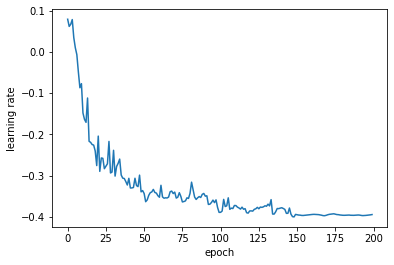

In [20]:
print('\nhistory val_loss:')
plt.figure()
plt.plot(np.arange(epochs), np.array(history.history['val_loss']))
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

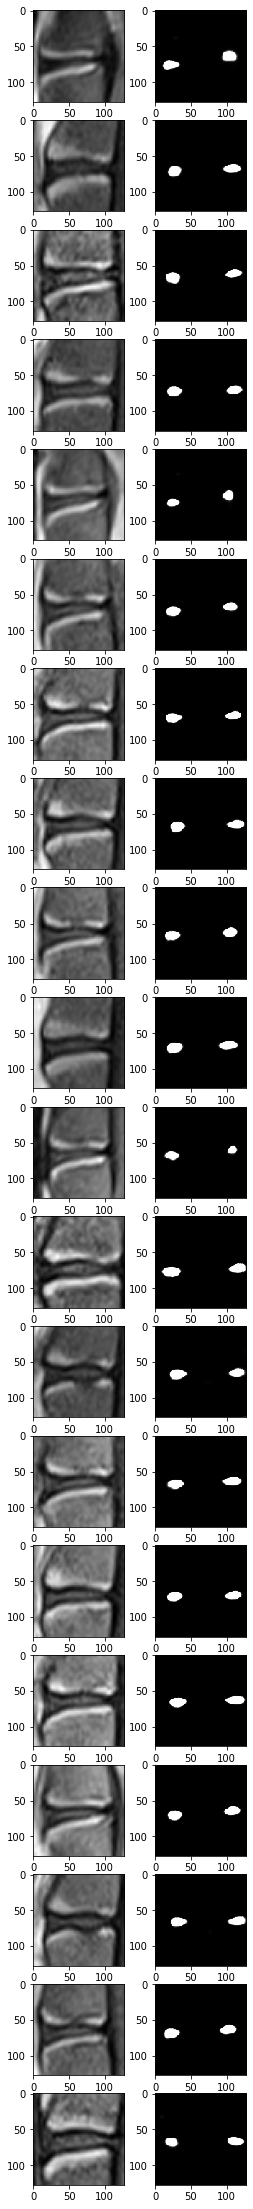

In [23]:
Y_pred = model.predict(X_test_unlabelled)
X_test_show = np.squeeze(X_test_unlabelled)
Y_pred_show = np.squeeze(Y_pred)

plt.figure(figsize=(4,40))
for i in range(20):
    plt.subplot(20,2,2*(i+1)-1)
    plt.imshow(X_test_show[i+50,:,:],cmap = 'gray')
    plt.subplot(20,2,2*(i+1))
    plt.imshow(Y_pred_show[i+50,:,:],cmap = 'gray')
plt.show()